# Anomaly Detection in SAR Images Using Siamese Networks and Contrastive Learning

## 💡 **Objective**
To detect anomalies in SAR images using a Siamese neural network. We train the model to learn an embedding space where:

- Similar (normal-normal) image patches are close together.

- Dissimilar (normal-anomaly) pairs are far apart.

**Option 1:** Use the data collector to build syntetic dataset of anomaly (=adding noise to image) and normal.

**Option 2:** To generate dissimilar pairs during training, we use pseudo-labels from an autoencoder: images with high ae = reconstruction error/vae = kl divergence loss are treated as anomalous candidates
 (Teacher-student).

**Option 3:** Fusion between models

## **⚙️ Training Strategies:**
### Option 1: Synthetic Anomalies (Data Collector)
Use a data augmentation pipeline or external anomaly collector to generate synthetic anomaly images.

This includes adding structured or unstructured noise, blur, cutout, or corruption to normal patches.

Construct training pairs:

- Positive: (normal, normal)

- Negative: (normal, synthetic anomaly)

### Option 2: Pseudo-Anomaly via Autoencoder
Use the autoencoder output and treat images with high reconstruction error as pseudo-anomalies.

Construct training pairs:

- Positive: (normal, normal)

- Negative: (normal, pseudo-anomaly)

## 🧮 **Contrastive Loss**

### 💡 Goal of the Loss
The goal is to penalize the network when:

- Similar pairs (label = 0) are too far in the embedding space.

- Dissimilar pairs (label = 1) are too close in the embedding space.


Let:

D = Euclidean distance between the two embeddings:
𝐷=∥𝑓(𝑥1)−𝑓(𝑥2)∥^2

y = label (0 if similar, 1 if dissimilar)

m = margin (e.g., 1.0 — how far apart dissimilar pairs should be)

Then the contrastive loss is:
$$
L = (1 - y) \cdot \frac{1}{2} D^2 + y \cdot \frac{1}{2} \left[ \max(0, m - D) \right]^2
$$


### 🔍 What This Does
- If y = 0 (similar pair):

$$L = \frac{1}{2} D^2$$

→ Loss is low when distance is small.

→ Network is rewarded for making embeddings close.

If y = 1 (dissimilar pair):

$$
L = \frac{1}{2} \left[ \max(0, m - D) \right]^2
$$

→ Loss is low when distance is greater than margin.

→ Network is rewarded for pushing embeddings farther apart.

## 🔍 **Inference Process**
At inference time, we use only one side of the Siamese network (the encoder) to embed each patch.

For a given test patch, we compute its embedding and compare it to one or more reference embeddings from known normal patches. The embedding distance (cosine/Euclidean) indicates how anomalous the test patch is.

### ✅ Option 1: Synthetic Anomalies
- Reference: Clean (normal) patches from the dataset.

- Compare: Test patch vs. known normal patches.

- High distance → anomaly.

### ✅ Option 2: Autoencoder-Based Pseudo Labels
- Reference: Patches with low reconstruction error from the autoencoder (assumed normal).

- Compare: Test patch vs. trusted normal patches.

- High distance → potential anomaly.

# 🛠️ Setup
I begin by preparing the dataset using the following scripts from our repository:

1. data_collector.py – Downloaded 298 Sentinel-1 SAR images.

2. sar_patcher.py – Preprocesses the images by extracting patches.

3. create_synthetic_anomaly_set() function – Generates a synthetic dataset by adding noise (salt-pepper) to selected patches to simulate anomalies.

## Offline work
1. Preprocess the data to create input pairs (similar and dissimilar) for training the Siamese network.

2. Train the Siamese network using contrastive loss.

3. Evaluate the model by comparing test patches to reference normal patches to detect anomalies.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📦 The Following Sections
In the next cells, I will walk through key stages of the pipeline, including data preparation, exploratory data analysis, and performance evaluation.

## 1. Data Preparation

### 🗂️ Dataset Split by ROI Samples

to reduce spatial bias while still evaluating generalization across similar regions, I selected regions of interest (ROIs) that are geographically close — all located along the U.S. West Coast, near longitudes -122.5, -120, -118, etc.. Each ROI was carefully assigned to a distinct dataset (training, validation, test or embedding dataset) to ensure clear separation during model training and evaluation.

This setup helps simulate real-world scenarios where training and test data come from nearby but non-overlapping regions, and it reduces the risk of overfitting to a specific geographical pattern.

Dataset construction uses scripts from our project repository:

**data_collector.py** - Downloads a total of 298 Sentinel-1 SAR images from the following ROIs:

  | Sample        | Image Count | ROI Coordinates                | Assigned To          |
  | ------------- | ----------- | ------------------------------ | -------------------- |
  | `sample1`  | 50          | `[-122.5, 37.5, -122.4, 37.6]` | Training Set         |
  | `sample2` | 100         | `[-120.5, 35.5, -120.4, 35.6]` | Training Set             |
  | `sample3`  | 50          | `[-124.5, 39.5, -124.4, 39.6]` | Test Set             |
  | `sample4`  | 50          | `[-118.5, 33.5, -118.4, 33.6]` | Embedding (Reference) |
  | `sample5`  | 48          | `[-117.5, 32.5, -117.4, 32.6]` | Embedding (Reference) |


    Dataset Roles Summary:
    Training Set (+validation): 150 images (sample1+2)
    Test Set: 50 images (sample3)
    Embedding (Reference) Set: 98 images (sample4 + sample5)

This division ensures that each set is geographically distinct, allowing the model to generalize better and reducing the risk of overfitting to specific regional patterns.

## 🧩 Patch Extraction from SAR Images
**sar_patcher.py** - Extracts fixed-size patches (128x128) from the raw SAR images, preparing them for use in model training and evaluation.

## 🧪 EDA of SAR Images
To better understand the structure and content of the Sentinel-1 SAR dataset, we begin with a visual inspection of the raw images and the extracted patches.

### 🔍 Visualizing Raw SAR Images
We load a .npy file containing the collected SAR images and visualize a few of them. Each image contains 2 channels, typically corresponding to different polarizations (e.g., VV and VH).

<Figure size 1000x600 with 0 Axes>

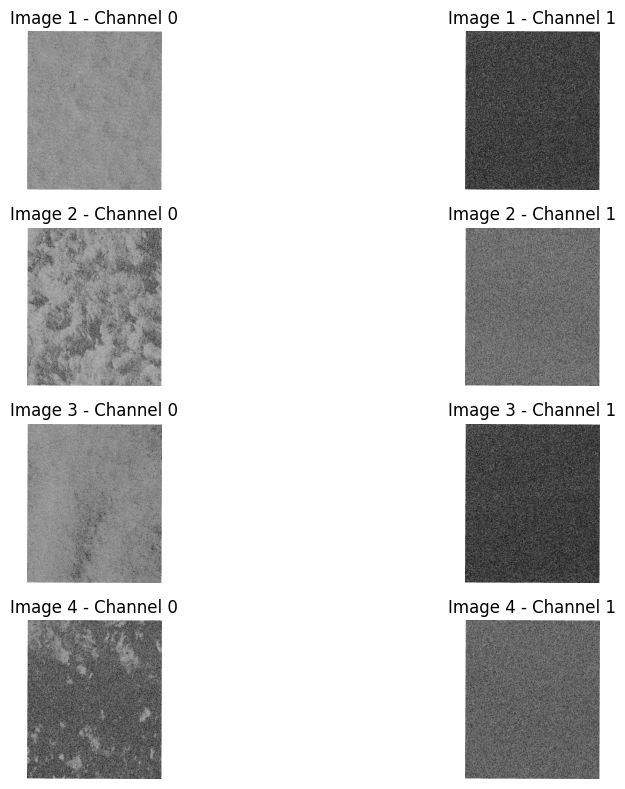

In [ ]:
# PLOT SOME IMAGES
import os
import numpy as np
import matplotlib.pyplot as plt

dataset_path = '/content/drive/My Drive/Asttera Project - Ydata/Notebooks/data_collector_298_imgs/collected_sar_array5.npy'
dataset_npy = np.load(dataset_path)

# Plot some images
plt.figure(figsize=(10, 6))

# Plot 4 images × 2 channels (total: 8 subplots)
plt.figure(figsize=(12, 8))

for i in range(4):  # first 4 images
    for ch in range(2):  # 2 channels
        plt.subplot(4, 2, i * 2 + ch + 1)
        plt.imshow(dataset_npy[i, :, :, ch], cmap='gray')
        plt.title(f"Image {i+1} - Channel {ch}")
        plt.axis('off')

plt.tight_layout()
plt.show()

### 🧩 Visualizing Extracted Patches

We also visualize an example of a patch extracted using **sar_patcher.py**. Patches are fixed-size slices of the full images (e.g., 128×128), used as inputs for the contrastive learning model.

In [ ]:
patch_path = '/content/drive/My Drive/Asttera Project - Ydata/Notebooks/data_collector_298_imgs/patches/sample5_0_patch_0003.npy'
patch_npy = np.load(patch_path)
print("Shape:", patch_npy.shape)
print("Data type:", patch_npy.dtype)

Shape: (128, 128, 2)
Data type: float64


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

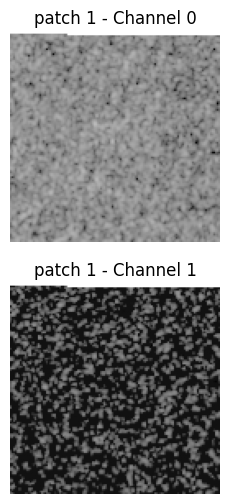

In [ ]:
# Plot 1 patch of image × 2 channels
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.imshow(patch_npy[:,:,0], cmap='gray')
plt.title("patch 1 - Channel 0")
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(patch_npy[:,:,1], cmap='gray')
plt.title("patch 1 - Channel 1")
plt.axis('off')

### ⚠️ Displaying Anomalies generated with our create_synthetic_anomaly_set() function
To train the Siamese network with dissimilar pairs, we need examples of anomalous data. Since labeled anomalies in SAR data are often scarce, we generate synthetic anomalies using our **create_synthetic_anomaly_set()** function.

This function simulates anomalies by injecting noise — such as salt-and-pepper noise — into selected normal patches. These altered patches mimic real-world anomalies (e.g., sensor artifacts, structural disruptions) and are used to create negative training pairs: **(normal patch, synthetic anomaly patch)**.

The synthetic anomaly patches are saved with a suffix _A.npy to distinguish them from normal ones.

### 🖼️ Visualizing a Synthetic Anomaly Patch

Below is an example of one such anomaly patch (you can see the S&P noise added). As with the normal patches, it contains 2 channels:

In [ ]:
patch_path = '/content/drive/My Drive/Asttera Project - Ydata/Notebooks/data_collector_298_imgs/patches/sample5_0_patch_0003_A.npy'
patch_a_npy = np.load(patch_path)
print("Shape:", patch_a_npy.shape)
print("Data type:", patch_a_npy.dtype)

Shape: (128, 128, 2)
Data type: float64


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

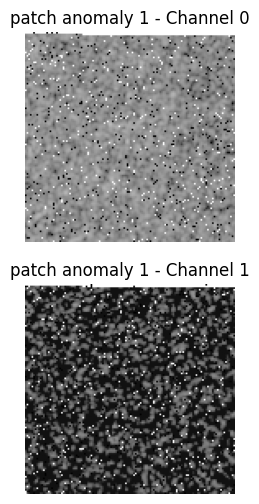

In [ ]:
# Plot 1 patch of image × 2 channels
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.imshow(patch_a_npy[:,:,0], cmap='gray')
plt.title("patch anomaly 1 - Channel 0")
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(patch_a_npy[:,:,1], cmap='gray')
plt.title("patch anomaly 1 - Channel 1")
plt.axis('off')

## 📊 Total Dataset Summary

Overall SAR Images Downloaded:

A total of **298** Sentinel-1 SAR images were collected from various regions of interest.

**Patch Extraction:**

From these images, approximately **15,888** patches were extracted (~54 patches per image on average) using the patch extraction pipeline.

**Anomaly Patches:**
Using synthetic anomaly generation, **3,177 patches (~20%)** were corrupted with noise to simulate anomalies.
The remaining **12,711 patches (~80%)** remained as normal.

## 🏋️‍♂️ Training & Validation Data

The training and validation sets contained approximately:

- 6,400 normal patches

- 1,600 synthetic anomaly patches

**Contrastive Learning Pairs:**

A total of **504 patch pairs** were constructed for training, with a balanced mix of:

- 253 positive pairs (normal-normal)

- 251 negative pairs (normal-anomaly)

**Batch Details:**

Example training batch shapes:
Patch 1: (8, 128, 128, 2);
Patch 2: (8, 128, 128, 2)

**Corresponding labels alternate between 0 (similar) and 1 (dissimilar).**

## 🗄️ Embedding Dataset

The embedding database used during inference contains 100 patches, evenly split between:

50 normal patches; 50 anomaly patches

## 🔎 Test Set
Inference Dataset:
**2,400 patches** for testing/inference.

## 🛠️ Model Evaluation Setup

For evaluating the anomaly detection performance on the test set, I used a two-step evaluation pipeline implemented in our project scripts:

1. **siames_model_evaluator.py:**

This script performs inference on test patches using the trained Siamese network and the embedding dataset (embedding dictionary):

- First, loads the trained Siamese model.

- Loads the embedding dataset (dictionary) containing known normal and anomaly patch embeddings.

- For each test patch:

a. Computes the embedding via the Siamese encoder.

b. Calculates Euclidean distances to embeddings in the database.

c. Finds the k nearest neighbors (default k=5).

d. Uses a majority vote among the neighbors' labels to assign a predicted label to the patch.

e. Produces an anomaly score representing the fraction of neighbors labeled anomalous.

- Finally, Saves predictions (filename, predicted label, anomaly score) to a CSV file.

This method captures similarity-based anomaly detection by comparing test patches to a trusted reference embedding space.

**2. predictions_csv_evaluator.py:**

This script evaluates the classification performance based on the CSV output from the previous step:

- Extracts ground truth labels directly from patch filenames (anomaly patches end with _A.npy).

- Compares ground truth labels with predicted labels.

- Calculates key metrics: Accuracy, Precision, Recall, F1 Score, ROC-AUC, Confusion Matrix.

## 📈 Test Set Evaluation Summary

The model was evaluated on 2,400 test patches, successfully detecting 977 anomalies.

Performance Metrics:
- **Accuracy:** 75.5%

- **Precision:** 44.4%

- **Recall (Sensitivity):** 90.4%

- **F1 Score:** 59.6%

- **ROC-AUC:** 87.6%

- **Confusion Matrix:**

|                | Predicted Normal | Predicted Anomaly |
| -------------- | ---------------- | ----------------- |
| Actual Normal  | 1,377            | 543               |
| Actual Anomaly | 46               | 434               |

The model shows high recall, meaning it successfully identifies most true anomalies, but at the cost of a relatively high number of false positives (543), which lowers precision. This trade-off reflects a cautious approach favoring anomaly detection over false alarms.

## ⏳ Future Work (Strech) and Next Steps

If time permits, we plan to perform a thorough error analysis to better understand the model’s false positives and false negatives. This will guide improvements such as experimenting with more complex architectures or advanced training strategies to boost performance.
However, due to time constraints, we have now shifted our focus to working with real-world SAR data provided by Asttera company, and have paused further experimentation on the public dataset. This transition will allow us to validate and adapt our approach in a practical, operational environment.